# Multi-Agent Deep Deterministic Policy Gradients (MADDPG)
---
In this notebook, I train Unity's Tennis environment using a multi-agent DDPG algorithm.

### Import the Necessary Packages

In [1]:
import random
import copy
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

### Set the training parameters

In [2]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = 500000  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 0.06              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 2        # time steps between network updates
N_UPDATES = 1           # number of times training
ADD_NOISE = True

#epsilon greedy params for exploration vs exploatation
EPS_START=1.0
EPS_END=0.05
EPS_DECAY=3e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Helper function for better initial weight setting

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

### Setup Actor and Critic Networks

In [4]:


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))




In [5]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


### Define the class to store experiences for training

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Random noise class
Ornstein Uhlenbeck process helps better than random noise in training

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

### Agent definition
Handles co-joint training of both agents handling the environment

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of agents
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.eps = EPS_START
        self.step_no = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)
    
    def step(self, state, action, reward, next_state, done, agent_number):
        self.step_no += 1
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn, if enough samples are available in memory and at interval settings
        if len(self.memory) > BATCH_SIZE:
            if self.step_no % UPDATE_EVERY == 0:
                for i in range(N_UPDATES):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, agent_number)

    def act(self, states, add_noise = True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        #if add_noise:
        #    actions += self.eps * self.noise.sample()
        if add_noise and (np.random.random() < self.eps):
            actions += self.noise.sample()
            #update the exploration parameter
            self.eps -= EPS_DECAY
            if self.eps < EPS_END:
                self.eps = EPS_END
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        # differntiate between the two, slice the initial action space
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

        # Update epsilon noise value
        #self.eps = self.eps - EPS_DECAY
        #if self.eps < EPS_END:
        #    self.eps=EPS_END
                  
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)            

    


### Initialize the environment

In [9]:
env = UnityEnvironment(file_name='./Tennis_Linux_NoVis/Tennis.x86_64', seed=1)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Explore the environment

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
#print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### Initialize and train the agents

In [11]:
agent_one = Agent(state_size, action_size, 1, random_seed=0)
agent_two = Agent(state_size, action_size, 1, random_seed=0)

In [12]:
episodes = 10000
scores_window = deque(maxlen=100)
scores_all = []
averages = []

for episode in range(episodes):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_one.reset()
    agent_two.reset()
    scores = np.zeros(num_agents)
    while True:
        action_one = agent_one.act(states)           # agent 1 chooses an action
        action_two = agent_two.act(states)           # agent 2 chooses an action
        # concatenate the actions and reshape them for the environment
        actions = np.reshape(np.concatenate((action_one, action_two), axis=0),(1,4)) 
        # send both agents' actions together to the environment
        env_info = env.step(actions)[brain_name]
        # get next states and reshape them 
        next_states = np.reshape(env_info.vector_observations,(1,48))         
        rewards = env_info.rewards                         # get reward
        done = env_info.local_done                         # see if episode finished
        agent_one.step(states, actions, rewards[0], next_states, done, 0) # train agent 1
        agent_two.step(states, actions, rewards[1], next_states, done, 1) # train agent 2
        
        
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step

        if np.any(done):                                  
            break

    max_score = np.max(scores)
    scores_window.append(max_score)
    scores_all.append(max_score)
    averages.append(np.mean(scores_window))
    # print training progression every now and then            
    if episode % 50 == 0:
        print('Episode {}\tMax Reward: {:.2f}\tAverage Reward: {:.3f}'.format(
            episode, max_score, np.mean(scores_window)))
    # check if we have reached the solved condition
    # if yes, print results and save agent networks weights for later use
    # and exit the training cycle
    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            episode, np.mean(scores_window)))
        torch.save(agent_one.actor_local.state_dict(), 'checkpoint_actor_one.pth')
        torch.save(agent_one.critic_local.state_dict(), 'checkpoint_critic_one.pth')
        torch.save(agent_two.actor_local.state_dict(), 'checkpoint_actor_two.pth')
        torch.save(agent_two.critic_local.state_dict(), 'checkpoint_critic_two.pth')
        break

Episode 0	Max Reward: 0.09	Average Reward: 0.090
Episode 50	Max Reward: 0.09	Average Reward: 0.007
Episode 100	Max Reward: 0.00	Average Reward: 0.012
Episode 150	Max Reward: 0.00	Average Reward: 0.014
Episode 200	Max Reward: 0.00	Average Reward: 0.018
Episode 250	Max Reward: 0.00	Average Reward: 0.028
Episode 300	Max Reward: 0.09	Average Reward: 0.027
Episode 350	Max Reward: 0.00	Average Reward: 0.031
Episode 400	Max Reward: 0.00	Average Reward: 0.054
Episode 450	Max Reward: 0.30	Average Reward: 0.088
Episode 500	Max Reward: 0.10	Average Reward: 0.117
Episode 550	Max Reward: 0.09	Average Reward: 0.138
Episode 600	Max Reward: 0.10	Average Reward: 0.154
Episode 650	Max Reward: 0.10	Average Reward: 0.203
Episode 700	Max Reward: 0.10	Average Reward: 0.252
Episode 750	Max Reward: 1.00	Average Reward: 0.299
Episode 800	Max Reward: 0.40	Average Reward: 0.462

Environment solved in 829 episodes!	Average Score: 0.501


### Rewards Graph

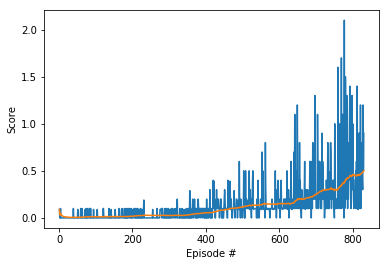

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(averages)+1), averages)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dispose the environment

In [14]:
env.close()